In [1]:
import os
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021')
from kalman_gst import *
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021/AdaptiveCircuit')
from pygsti.modelpacks import smq1Q_XYZI as std

In [2]:
def filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   Q_add, R_add, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False):
    param_history = []
    covar_history = []
    prior_innovs = []
    post_innovs = []
    kgains = []
    
    ekf = ExtendedKalmanFilter(prior_model.copy(), prior_covar)
    if save_params_and_covars:
        param_history.append(prior_model.to_vector())
        covar_history.append(prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        innov, kgain = ekf.update(circ, cvec, clip_range=clip_range, Q=Q_add, R_additional=R_add, max_itr=max_itr, itr_eps=itr_eps)
        if save_prior_innovations:
            prior_innovs.append(innov)
        if save_kgains:
            kgains.append(kgain)
        if save_posterior_innovations:
            post_predict = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
            post_innov = cvec/sum(cvec) - post_predict
            post_innovs.append(post_innov)
        if save_params_and_covars:
            param_history.append(ekf.model.to_vector())
            covar_history.append(ekf.P)
    return ekf.model, ekf.P, (param_history, covar_history, prior_innovs, post_innovs, kgains)

In [3]:
SEED = 2021
NUM_SHOTS = 256
np.random.seed(SEED)

In [49]:
# setup the datagen model
max_fogi_error_rate = 0.01
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [50]:
# check that the datagen model is CPTP and print metrics w.r.t. the target model
print('Model is CPTP... ', model_is_cptp(mdl_datagen))
print('avg. gate-set infidelity: ', avg_gs_infidelity(mdl_datagen, target_model))
print('mean square error: ', mserror(mdl_datagen, target_model))

Model is CPTP...  True
avg. gate-set infidelity:  0.009278804429917908
mean square error:  0.000771129612974869


In [51]:
# make an edesign and simulate the data
maxLengths = [1,2,4, 8]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, NUM_SHOTS, seed=SEED) #, sample_error='none')

In [52]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  128 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  258 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  531 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  874 circuits ---
Iterative GST Total Time: 2.4s


In [44]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

In [53]:
# run a Kalman filter in the usual way
prior_covar = 0.01*np.eye(target_model.num_params)
usual_post_model, usual_post_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[-1], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [00:46<00:00, 18.63it/s]


In [54]:
usual_parameter_history = saved_data[0]
usual_covar_history = saved_data[1]

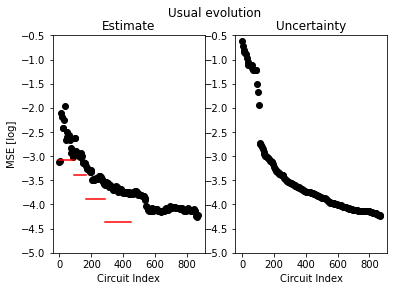

In [57]:
%matplotlib inline
plt_spacing = 5
yrange = [-5, -0.5]
make_error_plot('Usual evolution', usual_parameter_history, mdl_datagen.to_vector(), usual_covar_history, yrange, mle_estimates, germ_length_ranges, plt_spacing)

In [58]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

In [59]:
def fx(x, dt):
    return x

def model_wrapper(x_state, circ, model):
    model.from_vector(x_state)
    return vector_from_outcomes(model.probabilities(circ), 2**circ.width)

model = target_model
P = 0.1*np.eye(model.num_params)

dt = 1
points = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(model.num_params, 2, dt=0, hx=model_wrapper, fx=fx, points=points)
ukf.Q = 1e-9*np.eye(model.num_params)
R_add = 1e-9*np.eye(2)
ukf_filter_model = model.copy()

ukf.x = target_model.to_vector()
ukf.P = P

# Violations of linearity 

Use sigma points to calculate 
$$
    \Sigma = \sum_i w_i (h(x^{(i)}) - \bar{h}) (h(x^{(i)}) - \bar{h})^T
$$
and the nonlinear violation can be seen as a norm of  
$$
    \Sigma - H P H^T
$$


In [60]:
# do it once
model = target_model
P = 0.1*np.eye(model.num_params)
circ_list = edesign.circuit_lists[-1]

circ = circ_list[0]

merwe_def = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
sigma_points = merwe_def.sigma_points(model.to_vector(), P)
mean_weights = merwe_def.Wm
covar_weights = merwe_def.Wc

# calculate mean prediction and build the joint vectors
fid_model = model.copy()
mean_pred = np.zeros(2**circ.width)
predictions = []
for idx, x in enumerate(sigma_points):
    fid_model.from_vector(x)
    pred = vector_from_outcomes(fid_model.probabilities(circ), 2**circ.width)
    predictions.append(pred)
    mean_pred += mean_weights[idx]*pred
    
# calculate covariance 
dim_joint = 2**circ.width + model.num_params
sigma_covar = sum([
    covar_weights[i]*np.outer(predictions[i]-mean_pred, predictions[i]-mean_pred) 
    for i in range(len(sigma_points))
])

# calculate HPHt
jac = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
HPH = jac@P@jac.T

print(np.linalg.norm(HPH-sigma_covar))

1.016173180594349


In [61]:
# make a function to do it
def nonlinear_model_error(circ, model, model_covar, sigma_point_def):
    sigma_points = sigma_point_def.sigma_points(model.to_vector(), model_covar)
    mean_weights = sigma_point_def.Wm
    covar_weights = sigma_point_def.Wc

    # calculate mean prediction and build the joint vectors
    fid_model = model.copy()
    mean_pred = np.zeros(2**circ.width)
    predictions = []
    for idx, x in enumerate(sigma_points):
        fid_model.from_vector(x)
        pred = vector_from_outcomes(fid_model.probabilities(circ), 2**circ.width)
        predictions.append(pred)
        mean_pred += mean_weights[idx]*pred

    # calculate covariance 
    sigma_covar = sum([
        covar_weights[i]*np.outer(predictions[i]-mean_pred, predictions[i]-mean_pred) 
        for i in range(len(sigma_points))
    ])

    # calculate HPHt
    jac = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
    HPH = jac@P@jac.T
    
    return np.linalg.norm(HPH-sigma_covar)

In [95]:
%matplotlib inline

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:02<00:00,  3.71it/s]


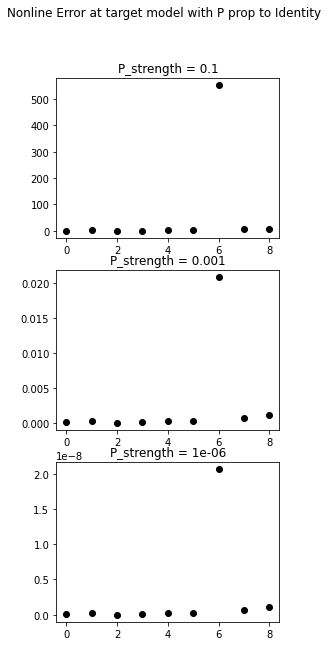

In [99]:
# plot a error vs circuit for a range of covariance strengths at the target
model = target_model
P_ranges = [0.1, 0.001, 0.000001]
circ_list = edesign.circuit_lists[-1]
circ_spacing = 100
sigma_point_def = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
fig, axs = plt.subplots(len(P_ranges),1, figsize=(5,5*len(P_ranges)))

for idp, p in enumerate(P_ranges):
    nonlin_errors = []
    for idx in tqdm( range(0, len(circ_list), circ_spacing) ):
        P = p*np.eye(model.num_params)
        nonlin_errors.append( nonlinear_model_error(circ_list[idx], model, P, sigma_point_def) )
    axs[idp].scatter(range(0, len(nonlin_errors)), nonlin_errors, c='black')
    axs[idp].set_title(f'P_strength = {p}')
fig.suptitle('Nonline Error at target model with P prop to Identity')
fig.savefig('nonlin_error_at_targetmodel.png')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.33it/s]


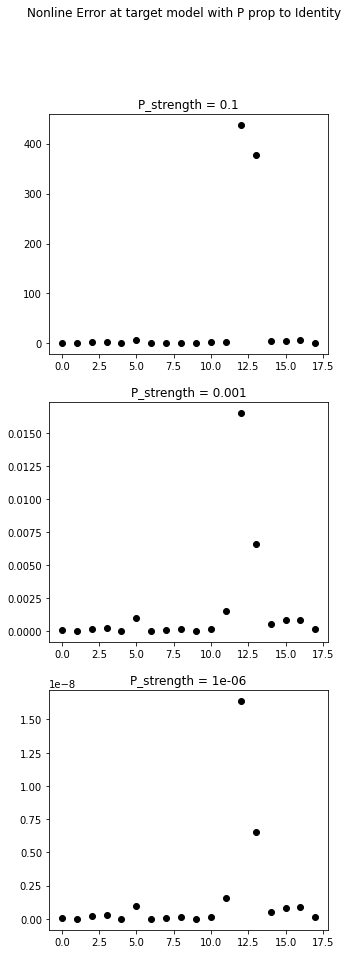

In [101]:
# same as above, but at a random noisy model
model = mdl_datagen
P_ranges = [0.1, 0.001, 0.000001]
circ_list = edesign.circuit_lists[-1]
circ_spacing = 50
sigma_point_def = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
fig, axs = plt.subplots(len(P_ranges),1, figsize=(5,5*len(P_ranges)))

for idp, p in enumerate(P_ranges):
    nonlin_errors = []
    for idx in tqdm( range(0, len(circ_list), circ_spacing) ):
        P = p*np.eye(model.num_params)
        nonlin_errors.append( nonlinear_model_error(circ_list[idx], model, P, sigma_point_def) )
    axs[idp].scatter(range(0, len(nonlin_errors)), nonlin_errors, c='black')
    axs[idp].set_title(f'P_strength = {p}')
fig.suptitle('Nonline Error at target model with P prop to Identity')
fig.savefig('nonlin_error_at_noisy.png')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:05<00:00,  3.29it/s]


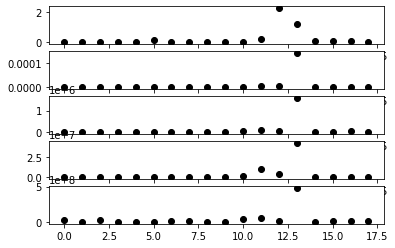

In [85]:
# now do it for equally spaced filter estimates
num_estimates = 5
circ_list = edesign.circuit_lists[-1]
circ_spacing = 50
sigma_point_def = MerweScaledSigmaPoints(target_model.num_params, alpha=.1, beta=2., kappa=-1)
fig, axs = plt.subplots(num_estimates,1)

fid_model = target_model.copy()
for ide in range(num_estimates):
    nonlin_errors = []
    for idx in tqdm( range(0, len(circ_list), circ_spacing) ):
        model_idx = int(np.floor(ide*(len(usual_parameter_history)/num_estimates)))
        fid_model.from_vector(usual_parameter_history[model_idx])
        P = usual_covar_history[model_idx]
        nonlin_errors.append( nonlinear_model_error(circ_list[idx], fid_model, P, sigma_point_def) )
    axs[ide].scatter(range(0, len(nonlin_errors)), nonlin_errors, c='black')

# Scoring

We'll create a score function motivated by mutual information, since the entropy of a gaussian r.v. is
$$
    H(x \sim \mathcal{N}(\mu, \Sigma) ) = \frac{D}{2}(1 + \log(2 \pi)) + \frac{1}{2} \log |\Sigma|
$$
where $|\Sigma| = \det(\Sigma)$

Let $(X, Y) \sim \mathcal{N}( (\bar{X}, \bar{Y}), \Sigma)$ where
$$
    \Sigma = \begin{bmatrix} \Sigma_X & \Sigma_{XY} \\ \Sigma_{YX} & \Sigma_{Y} \end{bmatrix}
$$
and consider
$$
    I(X;Y) = H(X) + H(Y) - H(X, Y)
$$ 
Given a prior $X$ and a prediction $Y$, the mutual informaiton is
$$
    \frac{D}{2}(1 + \log(2 \pi)) + \frac{1}{2} \log \frac{|\Sigma_X| |\Sigma_Y| }{|\Sigma|}
$$
Using properties of determinents, we can write 
$$
    |\Sigma| = |\Sigma_X - \Sigma_{XY} \Sigma_{Y}^{-1} \Sigma_{YX} | \times |\Sigma_{Y}|
$$
So the mutual information between jointly Gaussian r.v.'s $(X, Y)$ is 
$$
     \frac{1}{2} \log \frac{|\Sigma_Y| }{|\Sigma_X - \Sigma_{XY} \Sigma_{Y}^{-1} \Sigma_{YX}|}
$$
or
$$
     \frac{1}{2} \log \frac{|\Sigma_X| }{|\Sigma_Y - \Sigma_{YX} \Sigma_{X}^{-1} \Sigma_{XY}|}
$$

To deal with singularities in the invsere we might add sampling noise $R$ to the observation $Y$ and $Q$ to $X$. 

We'll do a numeric calculation for $\Sigma$ as 
$$
    \Sigma = \sum w^c (Z - \bar{Z})(Z - \bar{Z})^T 
$$
where $Z = (X, Y)$. We'll calculate $\bar{Y}$ per 
$$
    \bar{Y} = \sum w^m h(x^{(i)})
$$
where $x^(i)$ are sigma points 

c.f. https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/10-Unscented-Kalman-Filter.ipynb

To penalize circuits with large expected nonlinear error, we'll add in 
$$
    \sum w (h(x) - \bar{h})(h(x) - \bar{h})^T - HPH^T
$$
to the $Y$ part of the joint covars

In [102]:
from scipy.linalg import block_diag

/usr/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


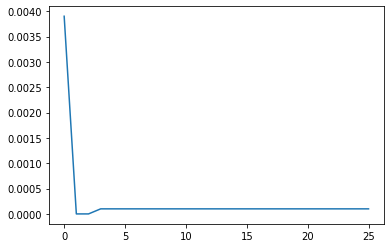

In [131]:
plt.plot(np.linalg.eigvals(jv_covar))

## A better score

Let's just look at $|\Sigma_X - \Sigma_{XY} \Sigma_{Y}^{-1} \Sigma_{YX}|$ but add nonlinear model error and sampling noise to $\Sigma_Y$

In [132]:
def make_joint_vectors(circ, model, model_covar, sigma_point_def):
    """
    make a set of joint samples of the form (X, Y) where X is the sigma point and Y is its prediction
    """
    sigma_points = sigma_point_def.sigma_points(model.to_vector(), P)
    
    fid_model = model.copy()
    joint_vectors = []
    for idx, x in enumerate(sigma_points):
        fid_model.from_vector(x)
        pred = vector_from_outcomes(fid_model.probabilities(circ), 2**circ.width)
        joint_vectors.append(np.hstack([x, pred]))
    return joint_vectors

In [177]:
def make_joint_covar(circ, model, model_covar, sigma_point_def):
    """
    make the joint covar 
    """
    jvs = joint_vectors(circ, model, P, sigma_point_def)

    mean_weights = sigma_point_def.Wm
    jv_mean = sum([mean_weights[i]*jvs[i] for i in range(len(mean_weights))])
    jv_covar = sum([
        sigma_point_def.Wc[i]*
        np.outer(jvs[i] - jv_mean, jvs[i] - jv_mean)
        for i in range(len(mean_weights))
    ])
    return jv_covar

def sigma_XY(joint_covar, num_params, hdims):
    assert joint_covar.shape[0] == num_params+hdims
    return joint_covar[0:num_params, num_params::]

def sigma_YY(joint_covar, num_params, hdims):
    assert joint_covar.shape[0] == num_params+hdims
    return joint_covar[num_params::, num_params::]

def sigma_XX(joint_covar, num_params, hdims):
    assert joint_covar.shape[0] == num_params+hdims
    return joint_covar[0:num_params, 0:num_params]

In [141]:
def make_sampling_covar(circ, model, num_samples):
    pvec = vector_from_outcomes(model.probabilities(circ), 2**circ.width)
    pseudo_counts = (num_samples*pvec + np.ones(2**circ.width))/(num_samples + 2**circ.width)
    return (1/(num_samples + 2**circ.width))*categorical_covar(pseudo_counts)

In [227]:
# make a function to do it
def nonlinear_model_covar(circ, model, model_covar, sigma_point_def):
    sigma_points = sigma_point_def.sigma_points(model.to_vector(), model_covar)
    mean_weights = sigma_point_def.Wm
    covar_weights = sigma_point_def.Wc

    # calculate mean prediction and build the joint vectors
    fid_model = model.copy()
    mean_pred = np.zeros(2**circ.width)
    predictions = []
    for idx, x in enumerate(sigma_points):
        fid_model.from_vector(x)
        pred = vector_from_outcomes(fid_model.probabilities(circ), 2**circ.width)
        predictions.append(pred)
        mean_pred += mean_weights[idx]*pred

    # calculate covariance 
    sigma_covar = sum([
        covar_weights[i]*np.outer(predictions[i]-mean_pred, predictions[i]-mean_pred) 
        for i in range(len(sigma_points))
    ])

    # calculate HPHt
    jac = matrix_from_jacob(model.sim.dprobs(circ), 2**circ.width)
    HPH = jac@P@jac.T
    
    return HPH - sigma_covar 

In [339]:
model = target_model
P = 0.000001*np.eye(model.num_params)
circ_list = edesign.circuit_lists[-1]

circ = circ_list[1]

sigma_point_def = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
jc = make_joint_covar(circ, model, P, sigma_point_def)
sxy = sigma_XY(jc, model.num_params, 2**circ.width)
syy = sigma_YY(jc, model.num_params, 2**circ.width)
sxx = sigma_XX(jc, model.num_params, 2**circ.width)

In [340]:
np.linalg.det(syy+R)

-6.451516047541132e-23

In [341]:
nonlin_covar = nonlinear_model_covar(circ, model, P, sigma_point_def)
print(np.linalg.norm(nonlin_covar))
R = make_sampling_covar(circ, model, 100)

2.5511341548145117e-12


In [342]:
np.linalg.pinv(syy)

array([[ 62500.01993074, -62500.01993074],
       [-62500.01993074,  62500.01993074]])

In [343]:
-np.log10(abs(np.linalg.det(syy- sxy.T@np.linalg.inv(sxx)@sxy)))

33.15712736698614

In [103]:
model = target_model
P = 0.0001*np.eye(model.num_params)
circ_list = edesign.circuit_lists[0]

circ = circ_list[-1]

merwe_def = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
sigma_points = merwe_def.sigma_points(model.to_vector(), P)
mean_weights = merwe_def.Wm
covar_weights = merwe_def.Wc

# calculate mean prediction and build the joint vectors
fid_model = model.copy()
mean_pred = np.zeros(2**circ.width)
joint_vectors = []
for idx, x in enumerate(sigma_points):
    fid_model.from_vector(x)
    pred = vector_from_outcomes(fid_model.probabilities(circ), 2**circ.width)
    mean_pred += mean_weights[idx]*pred
    joint_vectors.append(np.hstack([x, pred]))
    
# calculate joint covariance 
dim_joint = 2**circ.width + model.num_params
joint_covar = sum([covar_weights[i]*np.outer(joint_vectors[i], joint_vectors[i]) for i in range(len(sigma_points))])

# add in sampling error 
num_shots = 256
pseudo_counts = (num_shots*mean_pred + np.ones(mean_pred.shape))/(num_shots + 2**circ.width)
sampling_covar = (1/(num_shots + 2**circ.width))*(np.diag(pseudo_counts) - np.outer(pseudo_counts, pseudo_counts))

# add in a little process error 
process_error = 1e-6*np.eye(model.num_params)
joint_covar_perturbed = joint_covar + block_diag(process_error, sampling_covar)

In [17]:
np.linalg.det(joint_covar)

8.854470199079415e-104

In [110]:
np.linalg.eigvals(joint_covar)

array([1.00000000e-04, 1.99500146e+00, 9.00004879e-04, 4.93144848e-09,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04])

In [102]:
np.linalg.det(joint_covar_perturbed)

4.9292681866817635e-99

In [105]:
joint_covar_perturbed.shape

(26, 26)

In [108]:
np.linalg.eigvals(joint_covar_perturbed)

array([1.01000000e-04, 1.99500146e+00, 2.76796604e-03, 7.10046639e-05,
       1.01000000e-04, 1.01000000e-04, 1.01000000e-04, 1.01000000e-04,
       1.01000000e-04, 1.01000000e-04, 1.01000000e-04, 1.01000000e-04,
       1.01000000e-04, 1.01000000e-04, 1.01000000e-04, 1.01000000e-04,
       1.01000000e-04, 1.01000000e-04, 1.01000000e-04, 1.01000000e-04,
       1.01000000e-04, 1.01000000e-04, 1.01000000e-04, 1.01000000e-04,
       1.01000000e-04, 1.01000000e-04])

In [106]:
np.linalg.evals(joint_covar_perturbed)

AttributeError: module 'numpy.linalg' has no attribute 'evals'

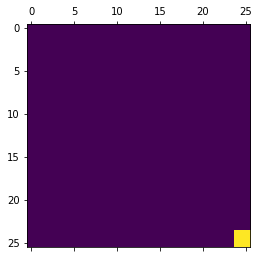

In [86]:
plt.matshow(joint_covar)

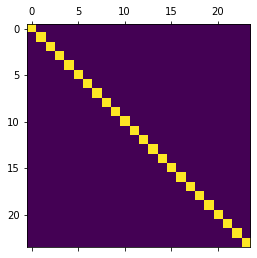

In [54]:
plt.matshow(joint_covar[0:-2, 0:-2])

In [55]:
# look at determinant of the joint covariance of the model and predictions 
def score_model(circ, model, sigma_points, sigma_weights):
    fid_model = model.copy()
    joint_samples = np.zeros((model.num_params+2**circ.width-1, len(sigma_points)))
    for idx, x in enumerate(sigma_points):
        fid_model.from_vector(x)
        y_pred = vector_from_outcomes(fid_model.probabilities(circ), 2**circ.width)
        joint_samples[:, idx] = np.hstack([x, y_pred[0]])
    return np.linalg.det(np.cov(joint_samples, aweights=abs(sigma_weights)))

In [56]:
print(merwe_points.Wm)

[-103.34782609    2.17391304    2.17391304    2.17391304    2.17391304
    2.17391304    2.17391304    2.17391304    2.17391304    2.17391304
    2.17391304    2.17391304    2.17391304    2.17391304    2.17391304
    2.17391304    2.17391304    2.17391304    2.17391304    2.17391304
    2.17391304    2.17391304    2.17391304    2.17391304    2.17391304
    2.17391304    2.17391304    2.17391304    2.17391304    2.17391304
    2.17391304    2.17391304    2.17391304    2.17391304    2.17391304
    2.17391304    2.17391304    2.17391304    2.17391304    2.17391304
    2.17391304    2.17391304    2.17391304    2.17391304    2.17391304
    2.17391304    2.17391304    2.17391304    2.17391304]


In [58]:
model = target_model
P = 0.1*np.eye(model.num_params)
circ_list = edesign.circuit_lists[0]

merwe_points = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
sigma_points = merwe_points.sigma_points(model.to_vector(), P)


score_model(circ_list[0], model, sigma_points, merwe_points.Wc)

4.11208392645386e-81

In [ ]:
# now swtich to adaptive filtering with sigma-point updates
num_updates = 10
show_output = True

circ_list = edesign.circuit_lists[-1] # now all the circuits in the maxlength exp
fid_model = target_model.copy()

adaptive_parameter_history = []
adaptive_covar_history = []

pbar = tqdm(total=num_updates)

current_update = 0
while(current_update < num_updates):
    fid_model.from_vector(ukf.x)
    circ, traces = find_best_circuit(circ_list, fid_model, ukf.P, NUM_SHOTS)
    if show_output:
        print('MSE: ', mserror(ekf.model, mdl_datagen))
        print('Best circ: ', circ)
        print('Predicted covar: ', traces[circ])

        plt.plot([v for v in traces.values()])
        plt.show()
    else:
        # show progress if not output
        pbar.update(1)
        
    counts = dataset[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    freq = (cvec+np.ones(len(cvec)))/(sum(cvec) + len(cvec))
    #req = cvec/sum(cvec)

    #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #ata_prior_innnovs[idx] = freq - p_filter_prior
    
    R_obs = categorical_covar(freq)/sum(cvec)
    ukf.predict()
    ukf.update(freq, R=R_obs+R_add, circ=circ, model=ukf_filter_model)
    adaptive_parameter_history.append(ukf.x)
    adaptive_covar_history.append(ukf.P)    
    
    current_update += 1
pbar.close()